In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:
bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/rotation/25h9/s_yaw_25h9_2m_1080_20.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60,75]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,6.243782
1,1.602319,26.098292
2,2.563932,24.184360
3,3.930854,-9.181095
4,4.855295,2.884018
...,...,...
288,104.261327,1.021224
289,104.603617,1.041435
290,105.002062,1.036191
291,105.198667,0.992223


<AxesSubplot:xlabel='relative_time'>

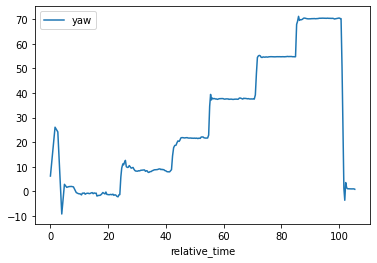

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 3)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

70

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

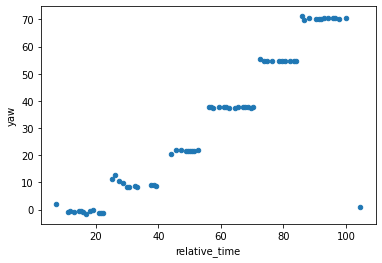

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.qcut(df_filtered_by_targets[target], len(input_vals), labels=input_vals, duplicates='drop')

In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>10].index)

In [13]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [14]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
13,11.052532,-0.727810,0,0.727810
15,11.727385,-0.629094,0,0.629094
54,25.072009,11.176175,15,3.823825
61,27.304808,10.503555,15,4.496445
111,44.149123,20.525177,30,9.474823
116,45.691530,21.865504,30,8.134496
147,56.069861,37.938834,45,7.061166
149,56.804265,37.739656,45,7.260344
195,72.344061,55.288907,60,4.711093
199,73.663709,54.672871,60,5.327129


In [15]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,12.0,0.823705,0.408963,0.250067,0.576889,0.717641,1.140243,1.600634
15,10.0,5.771181,0.964450,3.823825,5.405853,6.055282,6.504790,6.737571
30,10.0,6.775100,5.033937,-7.501365,8.134114,8.306899,8.340596,9.474823
45,12.0,7.305926,0.131613,7.061166,7.244773,7.336692,7.398910,7.490606
60,10.0,5.187783,0.176939,4.711093,5.186452,5.243017,5.245978,5.327129
75,12.0,4.625229,0.302363,3.844299,4.579372,4.629152,4.746396,5.188515


In [16]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

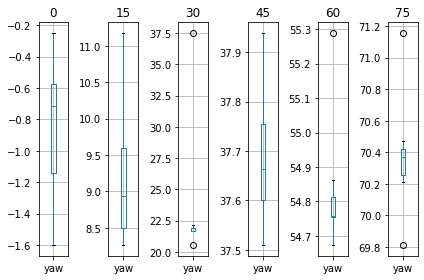

In [17]:
box_plotter(target)

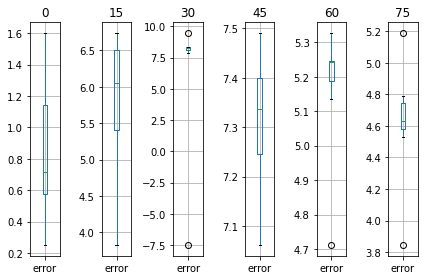

In [18]:
box_plotter('error')

In [19]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/rotations/result/csv/2m_25h9_1080.csv')